# Linear Model

The linear method makes use of the log backward return (log price difference) to predict foward return.

Training:
1) Ridge regression: on 30 features
2) PC regression: pca on 30 features then perform ols

Feature: 10 stocks, each with 3 backward return (say, 3min, 7min, 10min, see correlation to decide)

Response: 10 stocks' 30min forward return. 

Groups: [1,3,5,9],[2,4,7],[0],[3],[9]

## Data Preparation

In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

In [50]:
# Data Preparation
def logr(dta,min):
    return dta.diff(min,0).dropna()
x_begin_idx = log_pr.index[30]
x_end_idx = log_pr.index[-31]
y_begin_idx = log_pr.index[60]
group1 = [1,5,6,8]

# Group 1: {1,5,6,8}
x = pd.concat((logr(log_pr[group1],10)[x_begin_idx:x_end_idx],
                logr(log_pr[group1],20)[x_begin_idx:x_end_idx],
                logr(log_pr[group1],30)[x_begin_idx:x_end_idx]),axis=1)
y = log_pr[group1].diff(30)[y_begin_idx:]
y = y.set_index(x.index)

xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

In [104]:
# Group 2:
group2 = [9]
x = pd.concat((logr(log_pr[group2],10)[x_begin_idx:x_end_idx],
                logr(log_pr[group2],20)[x_begin_idx:x_end_idx],
                logr(log_pr[group2],30)[x_begin_idx:x_end_idx]),axis=1)
y = log_pr[group2].diff(30)[y_begin_idx:]
y = y.set_index(x.index)

xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

In [106]:
# Refitting the model with train&vali set
rr = Ridge(alpha=12).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A): 
    x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.array(group2), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat)#,np.corrcoef(r_fwd_all, r_hat_all)[0,1]

log_pr_test = log_pr[group2][log_pr.index[-44640]:]
evaluate(log_pr_test)

## Ridge Regression

### Model Tuning (MSE and Correlation) 

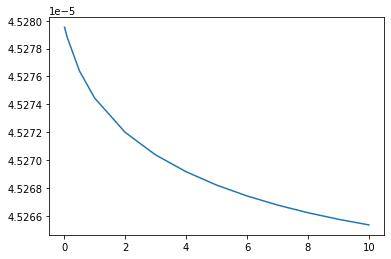

In [71]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_grid = np.array([0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10])
mse = np.empty(alpha_grid.shape[0])
for i in range(alpha_grid.shape[0]):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in group2},index=yvali.index)
    mse[i] = mean_squared_error(yvali,yvali_hat_ridge_a)
plt.plot(alpha_grid,mse)

In [72]:
rr = Ridge(alpha=10).fit(xtrain,ytrain)
# 10-minute-rolling 30-min log-return prediction for validation set
yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in group2},index=yvali.index)
# compute pairwise correlation
print(yvali_hat_ridge.corrwith(yvali[::10]))
#print(np.corrcoef(yvali_hat_ridge[::10],yvali[::10])[0,1])
# Compute mse
#from sklearn.metrics import mean_squared_error
#mean_squared_error(yvali,yvali_hat_ridge)

0    0.062328
2   -0.009268
dtype: float64


### Ridge Test Evaluation

In [96]:
# Refitting the model with train&vali set
rr = Ridge(alpha=12).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A): 
    x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.array(group2), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat)#,np.corrcoef(r_fwd_all, r_hat_all)[0,1]

log_pr_test = log_pr[group2][log_pr.index[-44640]:]
evaluate(log_pr_test)

Time used:  13.267999649047852


4    0.057132
7    0.002223
dtype: float64